<a href="https://colab.research.google.com/github/PETEROA/AutoML/blob/main/model_analysis_profilling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model Analysis and Profilling....
Here I perform comprehensive profiling of pretrained models to understand their computational characteristics.

Outputs:
- Model architecture summaries
- Computational profiles (FLOPs, parameters, memory)
- Inference latency benchmarks
- Bottleneck analysis
- Saved profiling data for downstream notebooks

In [1]:
!pip install torch torchvision transformers
!pip install thop  # For FLOPs calculation
!pip install ptflops  # Alternative FLOPs counter
!pip install torchinfo  # For detailed model summaries
!pip install matplotlib seaborn pandas numpy
!pip install py-cpuinfo psutil  # For hardware info

In [9]:
import torch
import torch.nn as nn
import torchvision.models as vision_models
from transformers import AutoModel, AutoTokenizer, AutoConfig
from thop import profile, clever_format
from torchinfo import summary
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Create output directory
OUTPUT_DIR = Path('/content/outputs') # Changed path from /mnt/user-data/outputs to an accessible Colab path
OUTPUT_DIR.mkdir(exist_ok=True)
PROFILES_DIR = OUTPUT_DIR / 'profiles'
PROFILES_DIR.mkdir(exist_ok=True)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cpu


In [10]:
## 1. Model Loading Functions
def load_vision_model(model_name='resnet18'):
    """Load a pretrained vision model"""
    model_dict = {
        'resnet18': vision_models.resnet18,
        'resnet50': vision_models.resnet50,
        'mobilenet_v2': vision_models.mobilenet_v2,
        'efficientnet_b0': vision_models.efficientnet_b0,
    }

    if model_name not in model_dict:
        raise ValueError(f"Model {model_name} not supported. Choose from {list(model_dict.keys())}")

    print(f"Loading {model_name}...")
    model = model_dict[model_name](pretrained=True)
    model.eval()
    return model

def load_language_model(model_name='bert-base-uncased'):
    """Load a pretrained language model"""
    print(f"Loading {model_name}...")
    model = AutoModel.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model.eval()
    return model, tokenizer

def get_model_size_mb(model):
    """Calculate model size in MB"""
    param_size = sum(p.nelement() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.nelement() * b.element_size() for b in model.buffers())
    size_mb = (param_size + buffer_size) / 1024**2
    return size_mb

In [11]:
## 2. Profiling Functions
def profile_vision_model(model, input_size=(1, 3, 224, 224), device='cpu'):
    """Profile a vision model"""
    model = model.to(device)
    dummy_input = torch.randn(input_size).to(device)

    # Calculate FLOPs and parameters
    flops, params = profile(model, inputs=(dummy_input,), verbose=False)
    flops, params = clever_format([flops, params], "%.3f")

    # Get detailed layer information
    model_summary = summary(model, input_size=input_size, verbose=0)

    # Measure inference time
    num_runs = 100
    model.eval()

    # Warmup
    with torch.no_grad():
        for _ in range(10):
            _ = model(dummy_input)

    # Timing
    if device.type == 'cuda':
        torch.cuda.synchronize()

    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_runs):
            _ = model(dummy_input)
            if device.type == 'cuda':
                torch.cuda.synchronize()
    end_time = time.time()

    avg_time_ms = (end_time - start_time) / num_runs * 1000

    # Memory usage
    model_size_mb = get_model_size_mb(model)

    profile_data = {
        'flops': flops,
        'params': params,
        'total_params': sum(p.numel() for p in model.parameters()),
        'trainable_params': sum(p.numel() for p in model.parameters() if p.requires_grad),
        'model_size_mb': model_size_mb,
        'inference_time_ms': avg_time_ms,
        'throughput_fps': 1000 / avg_time_ms,
        'input_size': input_size,
        'device': str(device)
    }

    return profile_data, model_summary

def profile_language_model(model, tokenizer, max_length=128, device='cpu'):
    """Profile a language model"""
    model = model.to(device)

    # Create dummy input
    dummy_text = "This is a sample sentence for profiling the language model."
    inputs = tokenizer(dummy_text, return_tensors='pt', padding='max_length',
                      max_length=max_length, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Calculate FLOPs and parameters
    # For transformers, we'll use a simplified approach
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Measure inference time
    num_runs = 100
    model.eval()

    # Warmup
    with torch.no_grad():
        for _ in range(10):
            _ = model(**inputs)

    # Timing
    if device.type == 'cuda':
        torch.cuda.synchronize()

    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_runs):
            _ = model(**inputs)
            if device.type == 'cuda':
                torch.cuda.synchronize()
    end_time = time.time()

    avg_time_ms = (end_time - start_time) / num_runs * 1000

    # Memory usage
    model_size_mb = get_model_size_mb(model)

    # Estimate FLOPs for transformer (approximate)
    # FLOPs ≈ 2 * num_params * sequence_length (rough estimate)
    approx_flops = 2 * total_params * max_length

    profile_data = {
        'params': f"{total_params / 1e6:.2f}M",
        'total_params': total_params,
        'trainable_params': trainable_params,
        'model_size_mb': model_size_mb,
        'inference_time_ms': avg_time_ms,
        'throughput_samples_per_sec': 1000 / avg_time_ms,
        'max_length': max_length,
        'approx_flops': f"{approx_flops / 1e9:.2f}G",
        'device': str(device)
    }

    return profile_data

In [12]:
# 3. Profile Vision Models
vision_models_to_profile = ['resnet18', 'resnet50', 'mobilenet_v2']
vision_profiles = {}

print("=" * 80)
print("PROFILING VISION MODELS")
print("=" * 80)

for model_name in vision_models_to_profile:
    print(f"\n{'='*80}")
    print(f"Model: {model_name}")
    print(f"{'='*80}")

    model = load_vision_model(model_name)
    profile_data, model_summary = profile_vision_model(model, device=device)
    vision_profiles[model_name] = profile_data

    # Display results
    print(f"\nModel: {model_name}")
    print(f"  Parameters: {profile_data['params']}")
    print(f"  FLOPs: {profile_data['flops']}")
    print(f"  Model Size: {profile_data['model_size_mb']:.2f} MB")
    print(f"  Inference Time: {profile_data['inference_time_ms']:.2f} ms")
    print(f"  Throughput: {profile_data['throughput_fps']:.2f} FPS")
    print(f"  Device: {profile_data['device']}")

    # Save profile
    with open(PROFILES_DIR / f'{model_name}_profile.json', 'w') as f:
        # Convert non-serializable values to strings
        serializable_profile = {k: str(v) if not isinstance(v, (int, float, str, list, dict)) else v
                               for k, v in profile_data.items()}
        json.dump(serializable_profile, f, indent=2)

    # Clean up
    del model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print(f"\n{'='*80}")
print("Vision model profiling complete!")
print(f"{'='*80}")

PROFILING VISION MODELS

Model: resnet18
Loading resnet18...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 104MB/s]



Model: resnet18
  Parameters: 11.690M
  FLOPs: 1.824G
  Model Size: 44.63 MB
  Inference Time: 95.25 ms
  Throughput: 10.50 FPS
  Device: cpu

Model: resnet50
Loading resnet50...
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 160MB/s]



Model: resnet50
  Parameters: 25.557M
  FLOPs: 4.134G
  Model Size: 97.70 MB
  Inference Time: 212.99 ms
  Throughput: 4.69 FPS
  Device: cpu

Model: mobilenet_v2
Loading mobilenet_v2...
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 118MB/s]



Model: mobilenet_v2
  Parameters: 3.505M
  FLOPs: 327.487M
  Model Size: 13.50 MB
  Inference Time: 31.46 ms
  Throughput: 31.79 FPS
  Device: cpu

Vision model profiling complete!


In [13]:
# Profile Language Models
language_models_to_profile = ['bert-base-uncased', 'distilbert-base-uncased']
language_profiles = {}

print("=" * 80)
print("PROFILING LANGUAGE MODELS")
print("=" * 80)

for model_name in language_models_to_profile:
    print(f"\n{'='*80}")
    print(f"Model: {model_name}")
    print(f"{'='*80}")

    model, tokenizer = load_language_model(model_name)
    profile_data = profile_language_model(model, tokenizer, device=device)
    language_profiles[model_name] = profile_data

    # Display results
    print(f"\nModel: {model_name}")
    print(f"  Parameters: {profile_data['params']}")
    print(f"  Approx FLOPs: {profile_data['approx_flops']}")
    print(f"  Model Size: {profile_data['model_size_mb']:.2f} MB")
    print(f"  Inference Time: {profile_data['inference_time_ms']:.2f} ms")
    print(f"  Throughput: {profile_data['throughput_samples_per_sec']:.2f} samples/sec")
    print(f"  Max Sequence Length: {profile_data['max_length']}")
    print(f"  Device: {profile_data['device']}")

    # Save profile
    with open(PROFILES_DIR / f'{model_name.replace("/", "_")}_profile.json', 'w') as f:
        serializable_profile = {k: str(v) if not isinstance(v, (int, float, str, list, dict)) else v
                               for k, v in profile_data.items()}
        json.dump(serializable_profile, f, indent=2)

    # Clean up
    del model, tokenizer
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print(f"\n{'='*80}")
print("Language model profiling complete!")
print(f"{'='*80}")

PROFILING LANGUAGE MODELS

Model: bert-base-uncased
Loading bert-base-uncased...


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


Model: bert-base-uncased
  Parameters: 109.48M
  Approx FLOPs: 28.03G
  Model Size: 417.65 MB
  Inference Time: 533.47 ms
  Throughput: 1.87 samples/sec
  Max Sequence Length: 128
  Device: cpu

Model: distilbert-base-uncased
Loading distilbert-base-uncased...


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


Model: distilbert-base-uncased
  Parameters: 66.36M
  Approx FLOPs: 16.99G
  Model Size: 253.16 MB
  Inference Time: 245.42 ms
  Throughput: 4.07 samples/sec
  Max Sequence Length: 128
  Device: cpu

Language model profiling complete!


In [14]:
# Visualization Comparison
# Create comparison DataFrame for vision models
vision_df = pd.DataFrame(vision_profiles).T
vision_df['model_name'] = vision_df.index
vision_df['total_params_m'] = vision_df['total_params'] / 1e6

print("\nVision Models Comparison:")
print(vision_df[['model_name', 'total_params_m', 'model_size_mb', 'inference_time_ms', 'throughput_fps']])


Vision Models Comparison:
                model_name total_params_m model_size_mb inference_time_ms  \
resnet18          resnet18      11.689512      44.62886         95.246828   
resnet50          resnet50      25.557032     97.695641        212.994294   
mobilenet_v2  mobilenet_v2       3.504872     13.501358         31.460886   

             throughput_fps  
resnet18          10.499037  
resnet50           4.694961  
mobilenet_v2        31.7855  


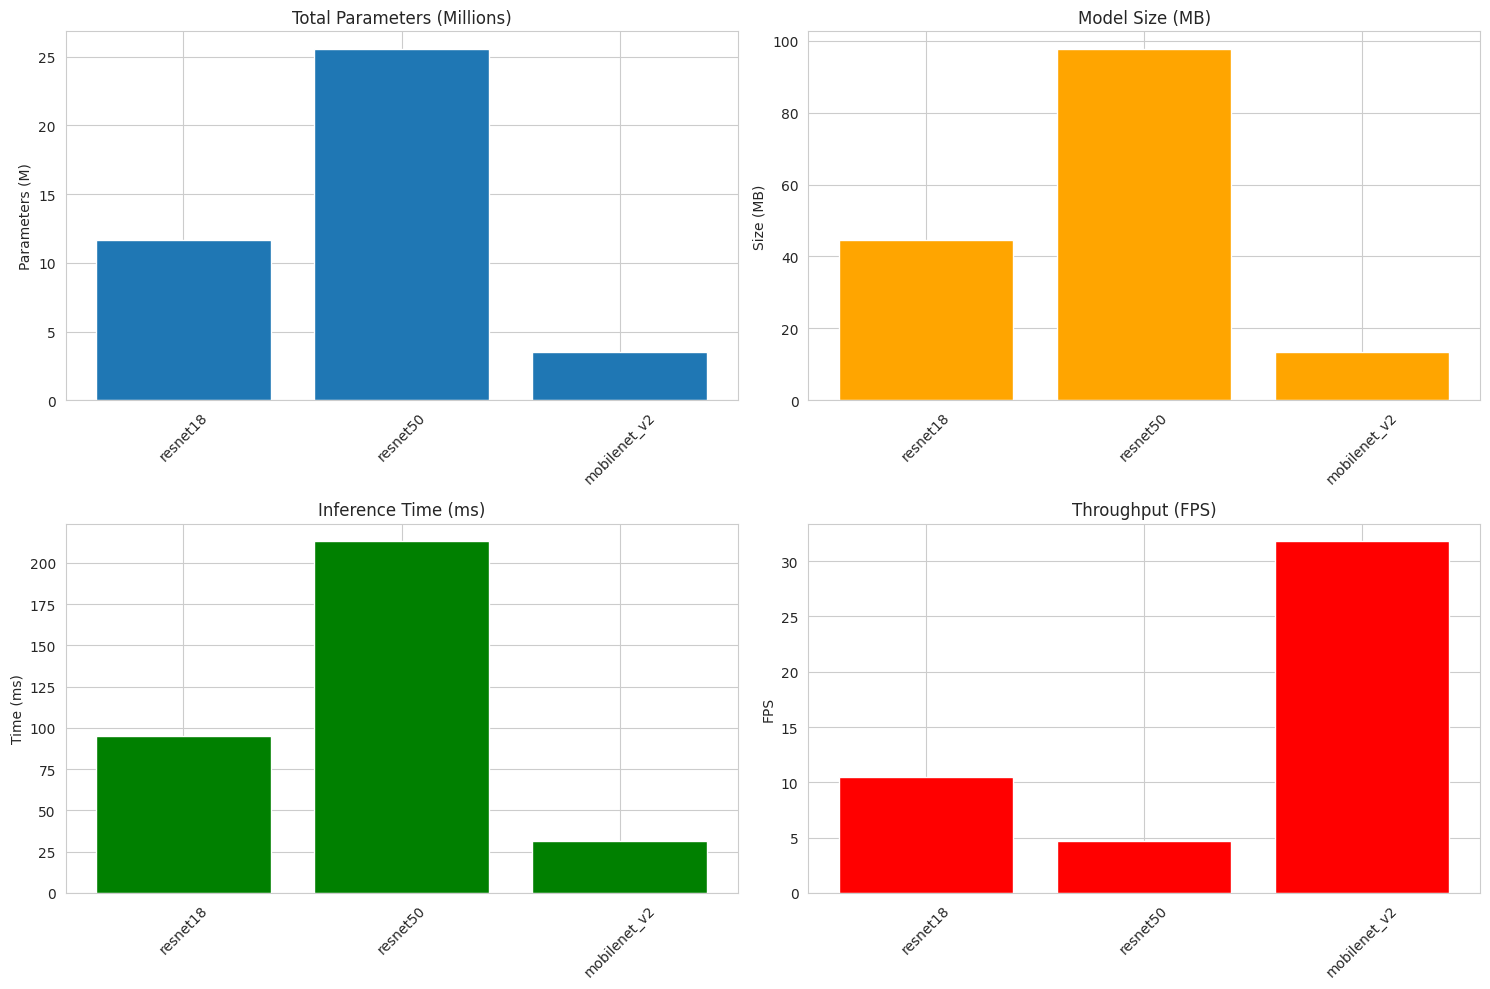


Visualization saved to: /content/outputs/vision_models_comparison.png


In [15]:
# Visualize vision models
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Parameters
axes[0, 0].bar(vision_df['model_name'], vision_df['total_params_m'])
axes[0, 0].set_title('Total Parameters (Millions)')
axes[0, 0].set_ylabel('Parameters (M)')
axes[0, 0].tick_params(axis='x', rotation=45)

# Model Size
axes[0, 1].bar(vision_df['model_name'], vision_df['model_size_mb'], color='orange')
axes[0, 1].set_title('Model Size (MB)')
axes[0, 1].set_ylabel('Size (MB)')
axes[0, 1].tick_params(axis='x', rotation=45)

# Inference Time
axes[1, 0].bar(vision_df['model_name'], vision_df['inference_time_ms'], color='green')
axes[1, 0].set_title('Inference Time (ms)')
axes[1, 0].set_ylabel('Time (ms)')
axes[1, 0].tick_params(axis='x', rotation=45)

# Throughput
axes[1, 1].bar(vision_df['model_name'], vision_df['throughput_fps'], color='red')
axes[1, 1].set_title('Throughput (FPS)')
axes[1, 1].set_ylabel('FPS')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'vision_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved to:", OUTPUT_DIR / 'vision_models_comparison.png')

In [16]:
# Create comparison DataFrame for language models
language_df = pd.DataFrame(language_profiles).T
language_df['model_name'] = language_df.index
language_df['total_params_m'] = language_df['total_params'] / 1e6

print("\nLanguage Models Comparison:")
print(language_df[['model_name', 'total_params_m', 'model_size_mb', 'inference_time_ms', 'throughput_samples_per_sec']])


Language Models Comparison:
                                      model_name total_params_m model_size_mb  \
bert-base-uncased              bert-base-uncased      109.48224    417.649414   
distilbert-base-uncased  distilbert-base-uncased       66.36288    253.158203   

                        inference_time_ms throughput_samples_per_sec  
bert-base-uncased              533.473215                   1.874508  
distilbert-base-uncased        245.416393                   4.074707  


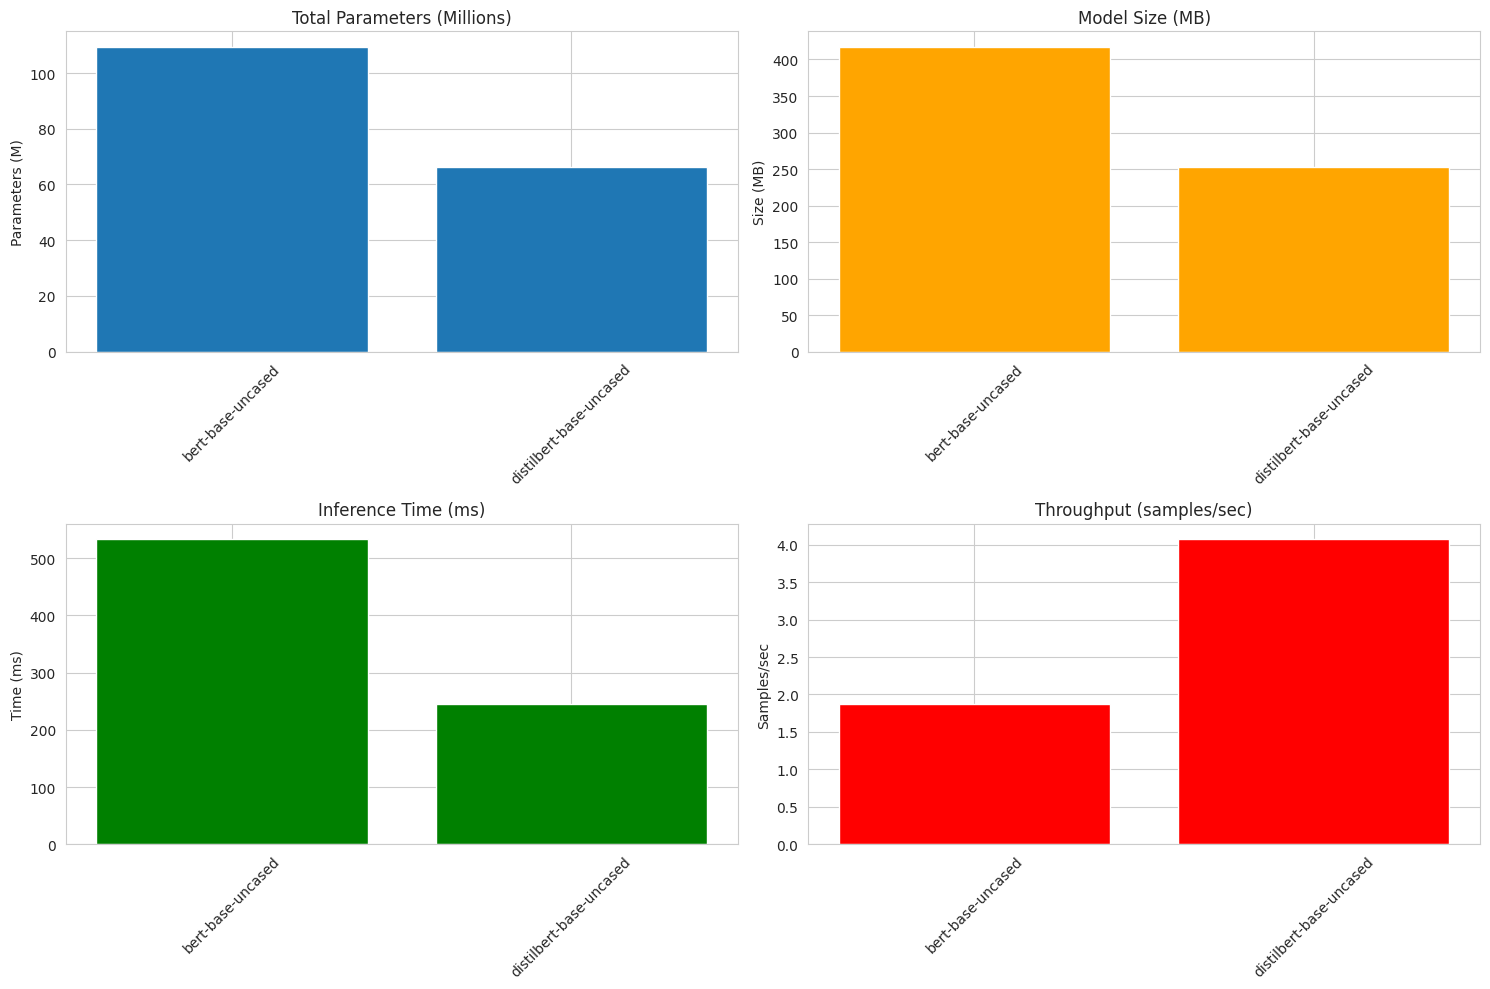


Visualization saved to: /content/outputs/language_models_comparison.png


In [17]:
# Visualize language models
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Parameters
axes[0, 0].bar(language_df['model_name'], language_df['total_params_m'])
axes[0, 0].set_title('Total Parameters (Millions)')
axes[0, 0].set_ylabel('Parameters (M)')
axes[0, 0].tick_params(axis='x', rotation=45)

# Model Size
axes[0, 1].bar(language_df['model_name'], language_df['model_size_mb'], color='orange')
axes[0, 1].set_title('Model Size (MB)')
axes[0, 1].set_ylabel('Size (MB)')
axes[0, 1].tick_params(axis='x', rotation=45)

# Inference Time
axes[1, 0].bar(language_df['model_name'], language_df['inference_time_ms'], color='green')
axes[1, 0].set_title('Inference Time (ms)')
axes[1, 0].set_ylabel('Time (ms)')
axes[1, 0].tick_params(axis='x', rotation=45)

# Throughput
axes[1, 1].bar(language_df['model_name'], language_df['throughput_samples_per_sec'], color='red')
axes[1, 1].set_title('Throughput (samples/sec)')
axes[1, 1].set_ylabel('Samples/sec')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'language_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved to:", OUTPUT_DIR / 'language_models_comparison.png')

In [18]:
#Save consolidated profiles
# Save all profiles in a single JSON file for easy loading in next notebooks
all_profiles = {
    'vision_models': vision_profiles,
    'language_models': language_profiles
}

# Convert to serializable format
def make_serializable(obj):
    if isinstance(obj, dict):
        return {k: make_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [make_serializable(item) for item in obj]
    elif isinstance(obj, (int, float, str, bool, type(None))):
        return obj
    else:
        return str(obj)

serializable_profiles = make_serializable(all_profiles)

with open(OUTPUT_DIR / 'all_model_profiles.json', 'w') as f:
    json.dump(serializable_profiles, f, indent=2)

print("\n" + "="*80)
print("All profiles saved to:", OUTPUT_DIR / 'all_model_profiles.json')
print("="*80)


All profiles saved to: /content/outputs/all_model_profiles.json


## Summary

I profiled:
- Vision models: ResNet-18, ResNet-50, MobileNetV2
- Language models: BERT-base, DistilBERT-base

Key metrics captured:
- Parameters count and model size
- FLOPs (computational complexity)
- Inference time and throughput
- Memory requirements

Outputs created:
- Individual model profiles in `/mnt/user-data/outputs/profiles/`
- Consolidated profile JSON: `/mnt/user-data/outputs/all_model_profiles.json`
- Comparison visualizations

